## Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Load the dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Split and preprocess the dataset

In [5]:
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

x_train, x_val, x_test = x_train / 255.0, x_val /255.0, x_test / 255.0

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

num_classes = len(np.unique(y_train))
print("num classes:", num_classes)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)
x_val shape: (5000, 32, 32, 3)
y_val shape: (5000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
num classes: 10


## Visualize some of images

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


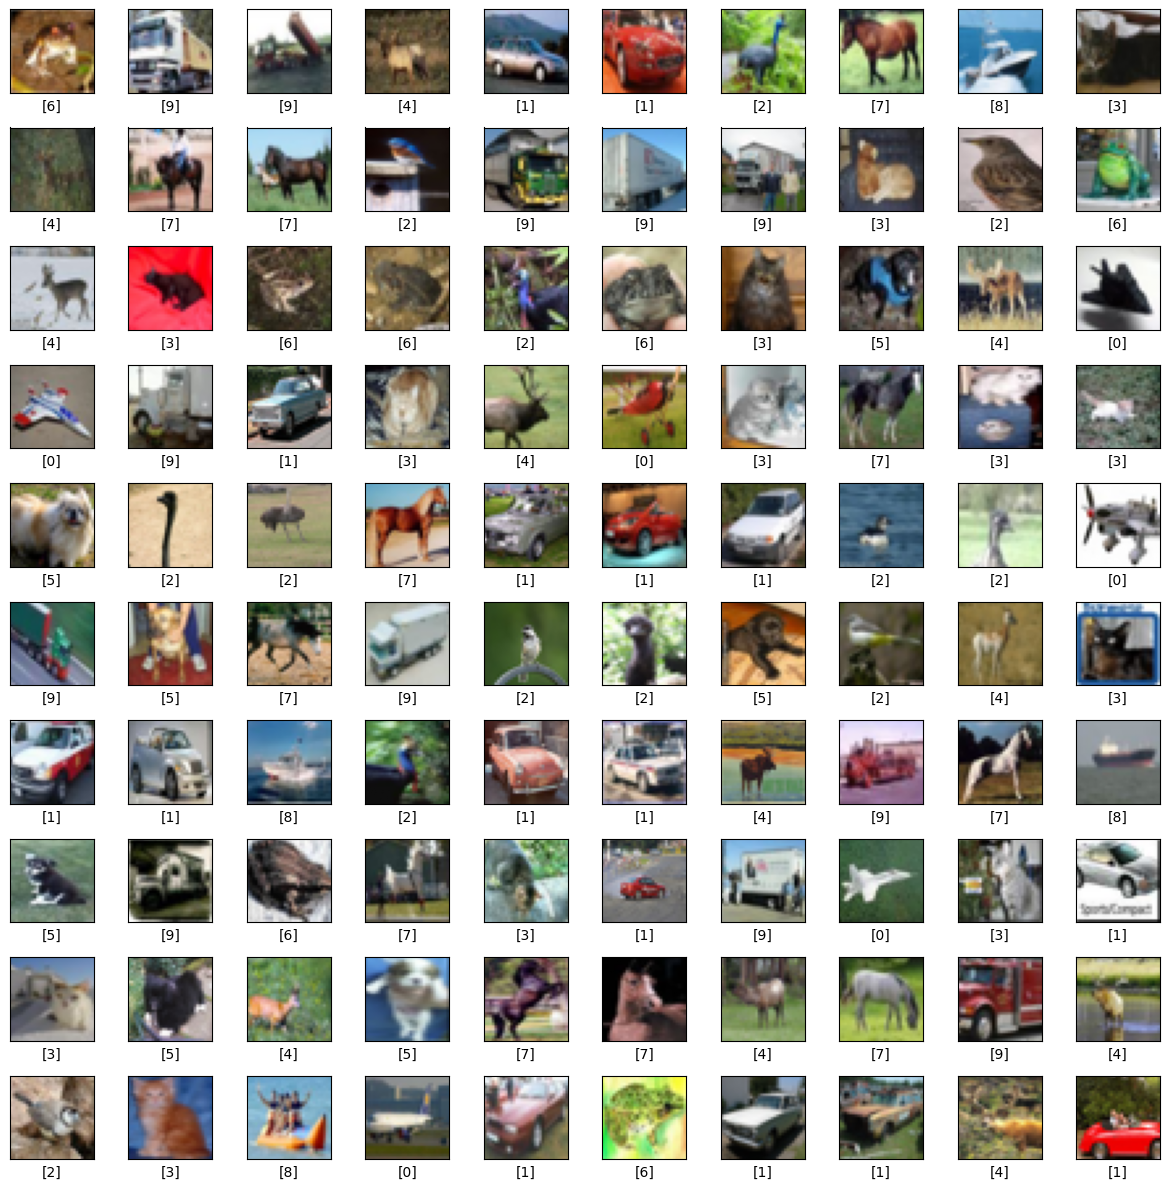

In [ ]:
def visualize_images(images, labels, num_images=100, grid_size=(10, 10)):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(labels[i])
    plt.tight_layout()
    plt.show()

visualize_images(x_train, y_train, num_images=100, grid_size=(10, 10))

## Create the model

* <b>Convolutional layers (Conv2D)</b> apply filters (kernels) to the input data to detect features such as edges, textures, and patterns. They perform convolution operations that result in feature maps, which highlight the presence of specific features at various spatial locations in the input image. By using multiple convolutional layers, the network can learn to identify complex patterns and hierarchical features, improving its ability to recognize objects and details within images.

* <b>MaxPooling layers</b> reduce the spatial dimensions (width and height) of the input feature maps by selecting the maximum value from each pooling window. This operation helps to downsample the feature maps, reducing the number of parameters and computational load, and makes the model more robust to spatial variations and noise. MaxPooling also helps to retain the most significant features detected by the convolutional layers.

* <b>Dropout</b> is a regularization technique used in neural networks to prevent overfitting. It works by randomly "dropping out" (setting to zero) a fraction of neurons during training, forcing the network to learn redundant representations and improving its generalization capabilities. This technique helps ensure that the model does not rely too heavily on any single neuron and improves its ability to perform well on unseen data.

* <b>Batch normalization</b> is a technique used to improve the training of deep neural networks. It normalizes the inputs of each layer by adjusting and scaling the activations, which helps in stabilizing the learning process and accelerating convergence. This can lead to faster training and improved overall performance of the model.

* The <b>Flatten layer</b> converts the 2D matrix of feature maps from the convolutional and pooling layers into a 1D vector. This transformation allows the resulting features to be fed into fully connected (dense) layers, enabling the model to learn and classify based on the combined features extracted from the previous layers. Flattening is a necessary step before connecting to dense layers for classification or regression tasks.

* <b>Dense layers</b>, also known as fully connected layers, are layers where each neuron is connected to every neuron in the previous layer. These layers process the flattened input by learning the complex relationships between the features and the output classes. Dense layers are crucial for combining features learned by convolutional layers to make final predictions. They are often used towards the end of the network in classification tasks, outputting probabilities for each class when using activation functions like softmax.


* Relu activation function:</br>
  <img src="https://s32.picofile.com/file/8478244076/image.png" alt="Image" width="600" height="300"></br>

  ReLU (Rectified Linear Unit) is an activation function commonly used in neural networks. It outputs the input directly if it is positive; otherwise, it outputs zero, introducing non-linearity and helping the network learn complex patterns.

* softmax activation function:</br>
    <img src="https://s32.picofile.com/file/8478244776/Softmax1.png" alt="Image" width="600" height="300"></br>
  Softmax is an activation function used in the output layer of classification models. It converts raw scores (logits) into probabilities by exponentiating each score and normalizing by the sum of all exponentiated scores, ensuring the outputs are in the range (0, 1) and sum to 1.

* L2 regularization, also known as weight decay, adds a penalty to the loss function proportional to the square of the magnitude of the model weights. This helps to prevent overfitting by discouraging large weights, encouraging the model to learn simpler patterns that generalize better to new data.


At the end, we wanted a model like VGG16. I have explained the architecture of the model in the document.

In [7]:
def create_model(input_shape=(32, 32, 1), num_classes=num_classes):
  """
  Create a CNN model with the specified input shape and number of output classes.

  Parameters:
  input_shape (tuple): Shape of the input images, default is (32, 32, 3).
  num_classes (int): Number of output classes, default is 10.

  Returns:
  model (Sequential): The constructed Keras Sequential model.
  """
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  return model

model = create_model()

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

## Compile the model

* Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
   1. .categorical_crossentropy: Loss function used for multi-class classification problems.
   2. adam: Adaptive moment estimation optimizer that adjusts learning rates during training
   3. metrics=['accuracy']: Metric to evaluate the model's performance during training and evaluation.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

* Train the model using the training data and evaluate on validation data.
  1. Augment data by shifting width and height by 10% and flipping horizontally.
  2. Calculates the number of steps per epoch based on the training set size and batch size.
  3. Configures a learning rate scheduler to reduce the learning rate when validation loss stops improving.
  4. x_train, y_train_one_hot: Training features and their one-hot encoded labels.
  5. batch_size=32: Number of samples processed before updating the model.
  6. epochs=50: Number of times the entire dataset is passed through the model during training.
  7. validation_data=(x_val, y_val_one_hot): Data used for evaluating the model's performance after each epoch.
   
 The `history` object will store training metrics such as loss and accuracy for each epoch.

In [11]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train_one_hot, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(train_generator,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_val, y_val_one_hot),
              batch_size=batch_size,
              callbacks=[reduce_lr]
             )

Epoch 1/50
1406/1406 [==============================] - 43s 28ms/step - loss: 1.7426 - accuracy: 0.3899 - val_loss: 1.3263 - val_accuracy: 0.5298 - lr: 0.0010
Epoch 2/50
1406/1406 [==============================] - 39s 28ms/step - loss: 1.3823 - accuracy: 0.5341 - val_loss: 1.0365 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 3/50
1406/1406 [==============================] - 39s 28ms/step - loss: 1.1948 - accuracy: 0.6181 - val_loss: 1.2600 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 4/50
1406/1406 [==============================] - 39s 28ms/step - loss: 1.1019 - accuracy: 0.6616 - val_loss: 1.0621 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 5/50
1406/1406 [==============================] - 38s 27ms/step - loss: 1.0514 - accuracy: 0.6904 - val_loss: 1.0561 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 6/50
1406/1406 [==============================] - 39s 27ms/step - loss: 1.0067 - accuracy: 0.7149 - val_loss: 0.9180 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 7/50
1406/1406 [========================

## Save the model

In [19]:
model.save('model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test the model

${precision} = \frac{TP}{\text{TP+FP}}$ </br></br>
${recall} = \frac{TP}{\text{TP+FN}}$ </br></br>
${F1-Score} = \frac{2*precision*recall}{\text{precision+recall}}$

In [12]:
eval = model.evaluate(x_test, y_test_one_hot)
print(f"Test accuracy: {eval[1]*100:.2f}")

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

print(classification_report(y_true, y_pred))

313/313 [==============================] - 1s 5ms/step - loss: 0.5030 - accuracy: 0.8833
Test accuracy: 88.33
313/313 [==============================] - 1s 2ms/step
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.94      0.96      0.95      1000
           2       0.87      0.81      0.84      1000
           3       0.83      0.72      0.77      1000
           4       0.88      0.87      0.88      1000
           5       0.84      0.83      0.83      1000
           6       0.82      0.96      0.89      1000
           7       0.91      0.92      0.92      1000
           8       0.94      0.93      0.94      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Plot the learning curves

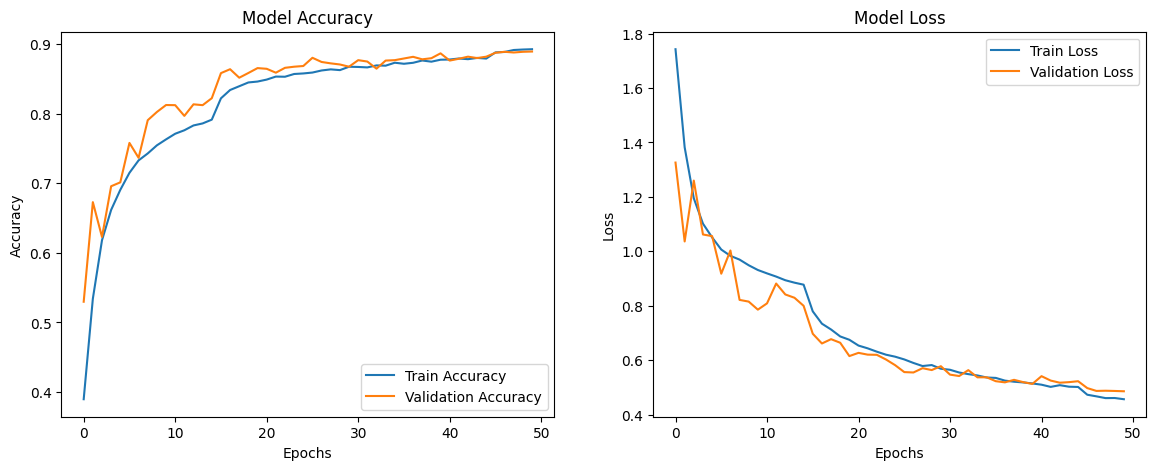

In [13]:
def plot_acc_loss():
    """
    Plots the accuracy and loss diagrams during model training.

    This function creates two subplots:
    - The first subplot shows the training and validation accuracy over epochs.
    - The second subplot shows the training and validation loss over epochs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

plot_acc_loss()

## Plot the ROC curve

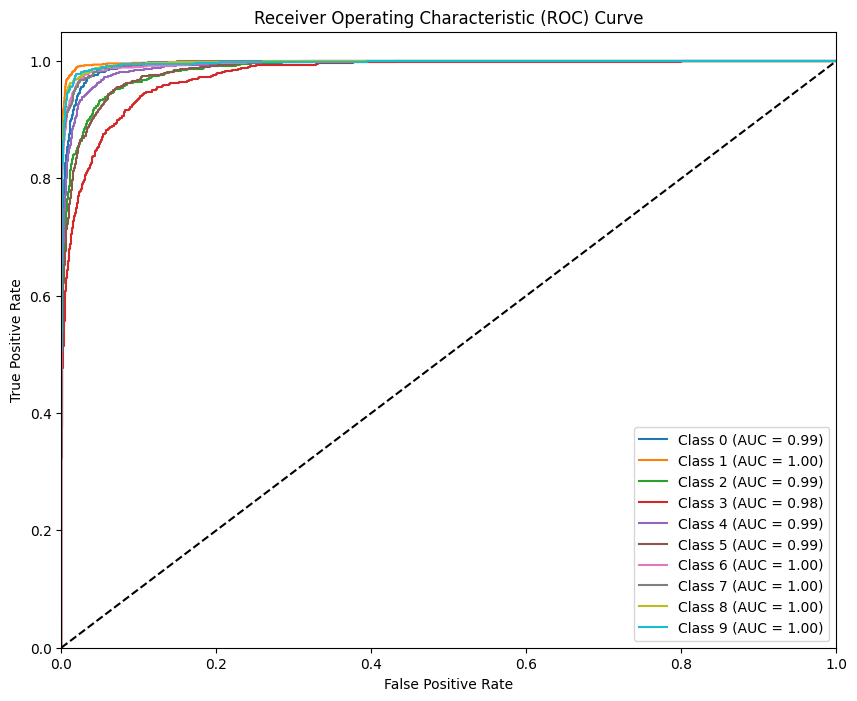

In [14]:
def plot_roc_curve():
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve()

## Plot the confusion matrix

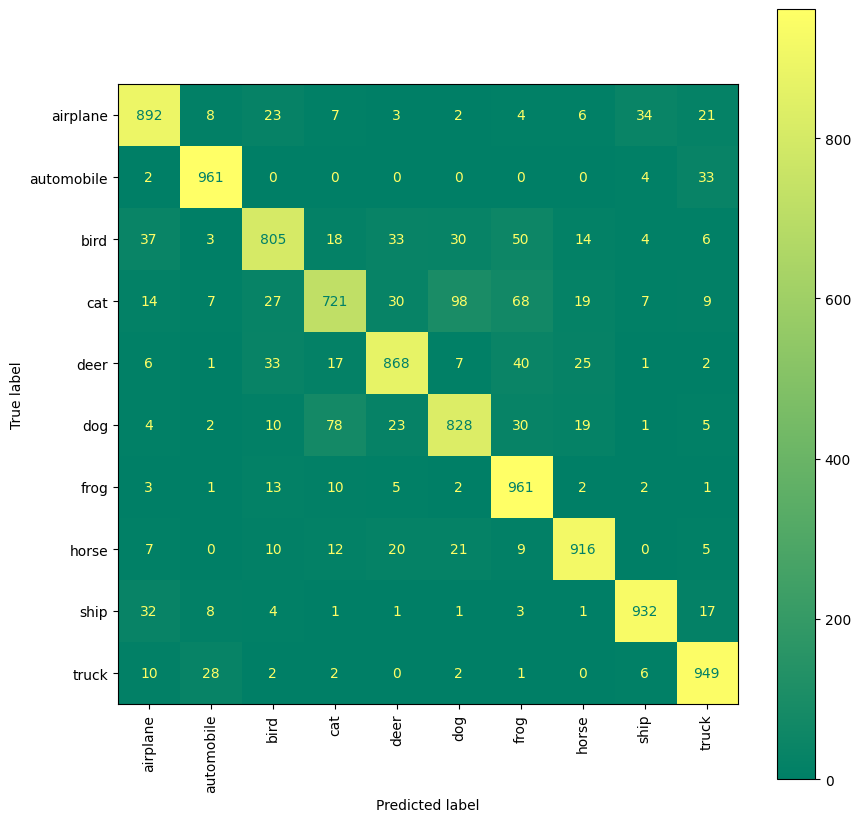

In [15]:
def plot_conf_matrix():
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)


    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

    plt.show()

plot_conf_matrix()

## Visualize some of the images with their predicted labels

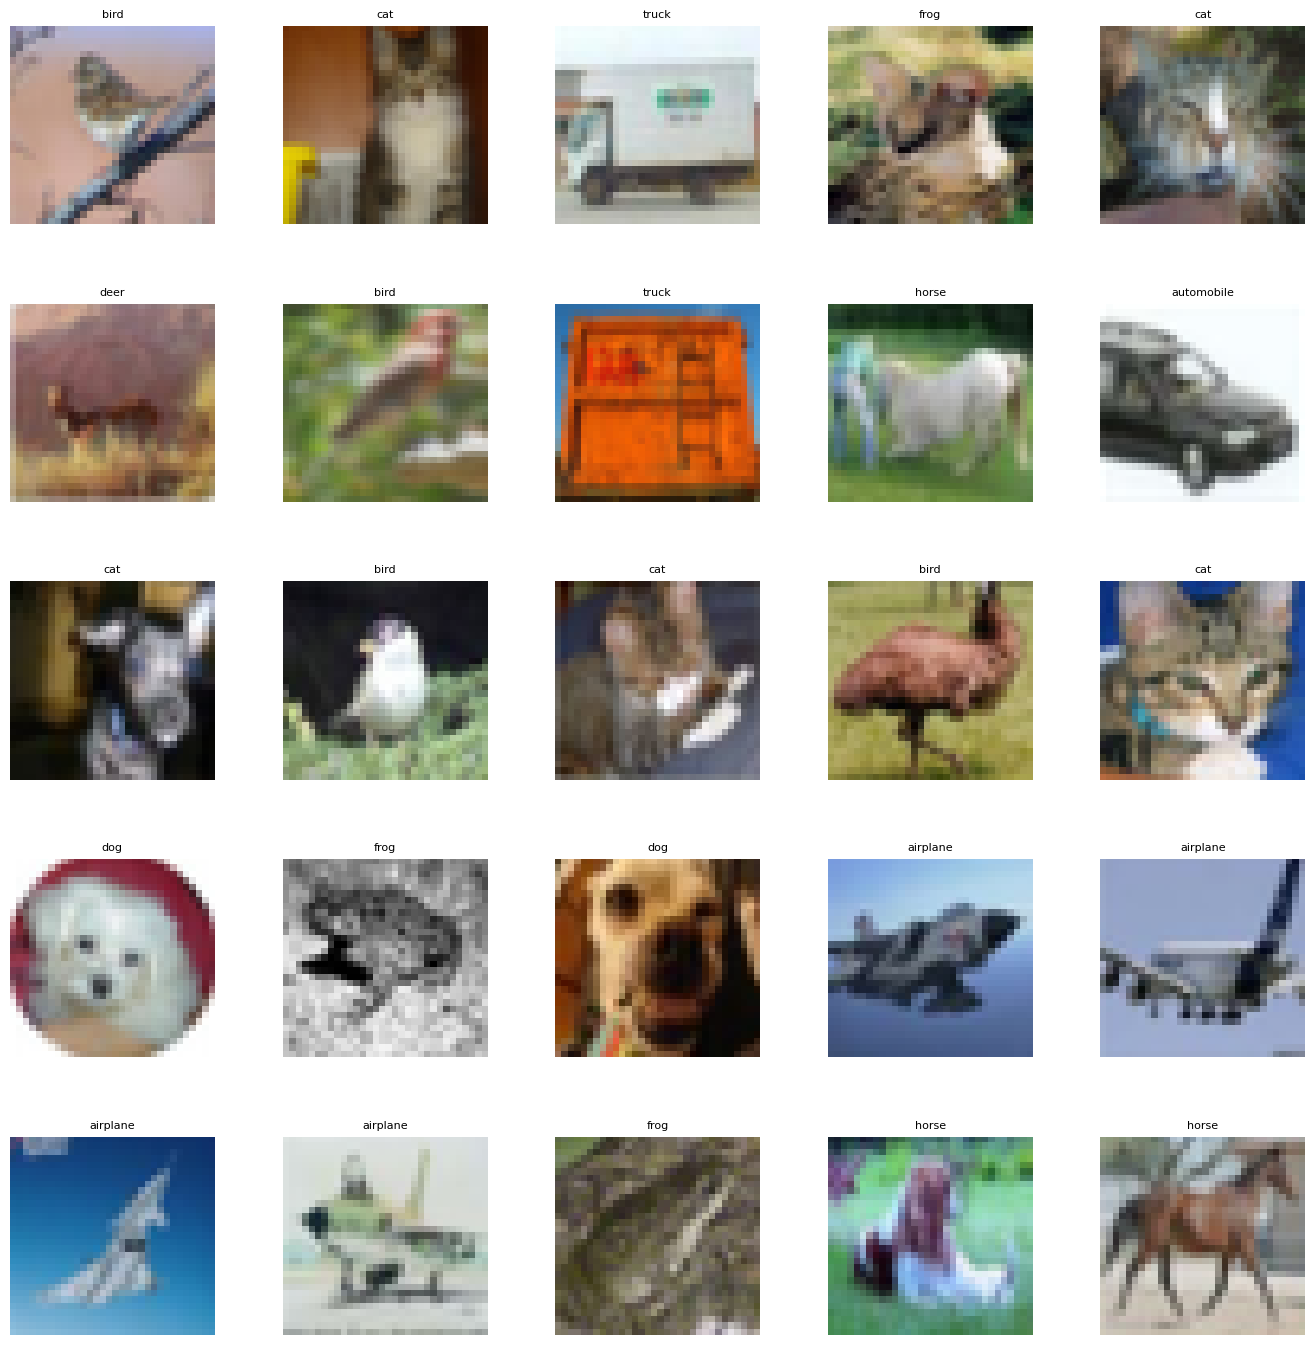

In [17]:
W_grid = 5
L_grid = 5
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']


fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel()
n_test = len(x_test)
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_test)
    axes[i].imshow(x_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)